In [1]:
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:

def read_data(file_name: str, hypothesis_flag) -> pd.DataFrame:
    """
    Load file containg details of LCA and retain only useful columns.
    Replace the column names with meaningful heads.
    :param filename: The path to the LCA data file.
    """

    col_required = ['STATUS', 'CASE_STATUS', 'LCA_CASE_EMPLOYER_NAME', 'EMPLOYER_NAME', 'TOTAL_WORKERS',
                    'TOTAL_WORKER_POSITIONS',
                    'LCA_CASE_WORKLOC1_STATE', 'VISA_CLASS', 'LCA_CASE_NUMBER', 'LCA_CASE_NAICS_CODE', 'NAICS_CODE',
                    'TOTAL WORKERS', 'WORKSITE_STATE', 'WORKSITE_STATE_1', 'CASE_NUMBER', 'NAIC_CODE']

    df = pd.read_csv(filepath_or_buffer=file_name, usecols=lambda x: x in col_required,
                     dtype={'LCA_CASE_NAICS_CODE': 'str',
                            'NAICS_CODE': 'str',
                            'NAIC_CODE': 'str',
                            },
                     low_memory=False, encoding='ISO-8859-1')

    df = df.rename(
        columns={'LCA_CASE_NUMBER': 'CASE_NUMBER', 'CASE_STATUS': 'STATUS', 'LCA_CASE_EMPLOYER_NAME': 'EMPLOYER_NAME',
                 'TOTAL_WORKER_POSITIONS': 'TOTAL_WORKERS', 'LCA_CASE_WORKLOC1_STATE': 'WORKSITE_STATE',
                 'LCA_CASE_NAICS_CODE': 'NAICS_CODE', 'WORKSITE_STATE_1': 'WORKSITE_STATE', 'NAIC_CODE': 'NAICS_CODE',
                 'TOTAL WORKERS': 'TOTAL_WORKERS'})
    if hypothesis_flag == False:
            df['STATUS'] = df["STATUS"].str.upper()
            df = df[(df['STATUS'] == 'CERTIFIED') & (df['VISA_CLASS'] == 'H-1B')]
            df['NAICS_CODE'] = df['NAICS_CODE'].str[:2]
            return (df)
    elif hypothesis_flag == True:
            df['STATUS'] = df["STATUS"].str.upper()            
            df['NAICS_CODE'] = df['NAICS_CODE'].str[:2]
            df = df[df['VISA_CLASS'] == 'H-1B']
            return (df)

In [3]:
def sector_range(row):
    if isinstance(row, list) and len(row) > 1:
        return list(range(int(row[0]), int(row[1]) + 1))
    elif isinstance(row, list):
        return row[0]

def read_sector_data (filename : str) -> pd.DataFrame:
    """
    Load the NAICS data file, retaining only the most useful columns & rows.
    Change the layout for a few rows to make the data inclusive of a codes.
    :param filename: The path to the NAICS code data file.
 
    """
    sector_df = pd.read_csv(filepath_or_buffer=filename,encoding='ISO-8859-1')
    sector_df["Sector"]=sector_df["Sector"].str.split("-")
    sector_df['sector_range'] = sector_df["Sector"].apply(sector_range)
    sector_codes = sector_df['sector_range'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index')
    sector_codes_final = sector_codes.merge(sector_df['Name'], left_index=True, right_index=True, how='inner')
    sector_codes_final = sector_codes_final.rename(columns={"value": "Sector"})
    sector_codes_final['Sector']= sector_codes_final['Sector'].astype('int8')
    return(sector_codes_final)

def hypothesis_one_cal(year_df, sector_data_df, yy):
    year_df =year_df.merge(sector_data_df, how='left', left_on='NAICS_CODE', right_on='Sector')
    stats_df = year_df.groupby(['Name'])['TOTAL_WORKERS'].sum().astype('int32').reset_index(name=yy)
    return( stats_df)

def hypothesis_one(file_list):
    sector_df = read_sector_data ('2017_NAICS_Structure_Summary_Table.csv')
    sector_df['Sector'] = sector_df['Sector'].astype('str')
    sector_name = sector_df.Name.unique().tolist()
    plot_data_df = pd.DataFrame()
    plot_data_df['Sectors']= sector_name
    for file in file_list:
        file_name = "data_H1B/" + file
        hypothesis_flag = False
        year_data = read_data (file_name, hypothesis_flag)
        year = '20' + file[7:9]
        stats = hypothesis_one_cal(year_data,sector_df,year)
        plot_data_df = plot_data_df.merge(stats, how='left', left_on='Sectors', right_on='Name')
        del plot_data_df['Name']
    return(plot_data_df)

In [60]:
def hypothesis_two(directory):
    country = ['China - mainland', 'China - Taiwan','India', 'Korea, South', 'Mexico','Brazil', 'Australia', 'Russia','Great Britain and Northern Ireland',
                'Germany','France', 'Philippines']
    sd= pd.DataFrame({"Nationality": country})
    for file in directory:
        col_name = 'Fiscal Year 20' + file[2:4]
        file_name = "data_Country/" + file
        df = pd.read_csv(filepath_or_buffer=file_name,thousands=',', dtype= {'H-1B':'float'})
        df=df.rename(columns={'Unnamed: 0': 'Visa_Country', col_name: 'Visa_Country'})
        df= df[['Visa_Country','H-1B']]
        df= df.rename(columns ={'H-1B': col_name})
        sd =sd.merge(df, how='left',  left_on= 'Nationality', right_on='Visa_Country')
        del sd['Visa_Country']
    plot_hypothesis_two(sd)
    return (sd)
def plot_hypothesis_two(data_plot):
    data_plot = data_plot.set_index('Nationality')
    data_plot = data_plot.T
    data_plot = data_plot.pct_change()    
    plot_data_df_forplot = data_plot[['China - mainland', 'China - Taiwan','India', 'Mexico', 'Russia']]
    plot_data_df_forplot.plot(ylabel="% change in number of H-1B visas", xlabel="Year", kind="bar", figsize = (18,9), width = 0.6)
    plt.legend(bbox_to_anchor = (1.1, 1.05))
    plt.show

In [5]:
def df_hypothesis_three(file_list):
    company_df = pd.read_csv("companylist.csv", dtype={'MarketCap': 'float64'})
    final_df = pd.DataFrame()
    list_of_df = []
    for file in file_list:
        file_name = "data_H1B/" + file
        hypothesis_flag = True
        year_data = read_data (file_name, hypothesis_flag)
        year = '20' + file[7:9]
        company_df['name_lower'] = company_df['Name'].str.lower()
        year_data['EMPLOYER_NAME_lower'] = year_data['EMPLOYER_NAME'].str.lower()
        companylist_merged_df = year_data.merge(company_df, left_on='EMPLOYER_NAME_lower', right_on='name_lower')
        companylist_merged_df_certified = pd.DataFrame()
        companylist_merged_df_total = pd.DataFrame()
        companylist_merged_df_total = companylist_merged_df.groupby(['EMPLOYER_NAME','MarketCap'])['TOTAL_WORKERS'].sum().reset_index(name="TOTAL_WORKERS_OVERALL")
        companylist_merged_df_certified = companylist_merged_df[companylist_merged_df['STATUS'] == 'CERTIFIED'].groupby(['EMPLOYER_NAME','MarketCap'])['TOTAL_WORKERS'].sum().reset_index(name="CERTIFIED_TOTAL_WORKERS")
        companylist_merged_df_certified['year'] = year
        companylist_merged_df_total['year'] = year
        new_data = companylist_merged_df_certified.merge(companylist_merged_df_total, on='EMPLOYER_NAME')  
        new_data['MarketCap_x'].astype('float64')
        new_data['Rate'] = (new_data['CERTIFIED_TOTAL_WORKERS'] / new_data['TOTAL_WORKERS_OVERALL'])*100
        new_data = new_data[['EMPLOYER_NAME', 'Rate', 'MarketCap_x','year_x']]
        #print(new_data.sort_values(by='Rate', ascending=False))
        list_of_df.append(new_data)
    final_df = pd.concat(list_of_df,ignore_index=True)
    return final_df   

In [6]:
def hypothesis_two_state_cal(states_data_df, year_df, yy):
    year_df =year_df.merge(states_data_df, how='left', left_on='WORKSITE_STATE', right_on='Abbreviation')
    stats_df = year_df.groupby(['State'])['TOTAL_WORKERS'].sum().reset_index(name=yy)
    return( stats_df)

def hypothesis_two_state(file_list):
    states_df = pd.read_csv('states.csv')
    state_name = states_df.State.unique().tolist()
    plot_data_df = pd.DataFrame()
    plot_data_df['Worksite State']= state_name
    for file in file_list:
        file_name = "data_H1B/" + file
        hypothesis_flag = False
        year_data = read_data (file_name, hypothesis_flag)
        year = '20' + file[7:9]
        stats = hypothesis_two_state_cal(states_df,year_data, year)
        plot_data_df = plot_data_df.merge(stats, how='left', left_on='Worksite State', right_on='State')
        del plot_data_df['State']
    plot_data_df = plot_data_df.set_index('Worksite State')
    plot_data_df = plot_data_df.apply(lambda s: pd.Series(s.nlargest(5).index))
    
    return(plot_data_df)

In [7]:

if __name__ == '__main__':
    path = "data_H1B/"
    directory = os.listdir(path)
    path2 = "data_Country/"
    directory2 =os.listdir(path2)
  

## Hypothesis 1

In [37]:
df = hypothesis_one(directory)

In [38]:
df

,Sectors,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,"Agriculture, Forestry, Fishing and Hunting",452,457,401,393,462,415,426,531,281,212
1,"Mining, Quarrying, and Oil and Gas Extraction",1464,1669,1607,1808,1635,1227,1225,1201,1085,1023
2,Utilities,971,983,881,1023,991,972,1108,1098,1226,1120
3,Construction,1944,2008,1798,1914,2431,2546,2792,3324,3718,3056
4,Manufacturing,37772,38182,48551,57489,58325,80784,122594,146438,154359,152264
5,Wholesale Trade,4829,5025,5634,5953,7161,7253,7567,7268,7030,5411
6,Retail Trade,7660,10274,10895,12841,17770,16378,22453,26537,28070,32169
7,Transportation and Warehousing,1586,1691,1486,1734,1889,1938,2315,2634,2612,2396
8,Information,25867,32893,22842,28226,36460,43883,50057,56962,62731,63067
9,Finance and Insurance,17025,15949,17371,22244,25191,32069,34703,38859,39831,40386


In [39]:
df= df.set_index('Sectors')
df = df.T
df=df.pct_change()

<function matplotlib.pyplot.show(close=None, block=None)>

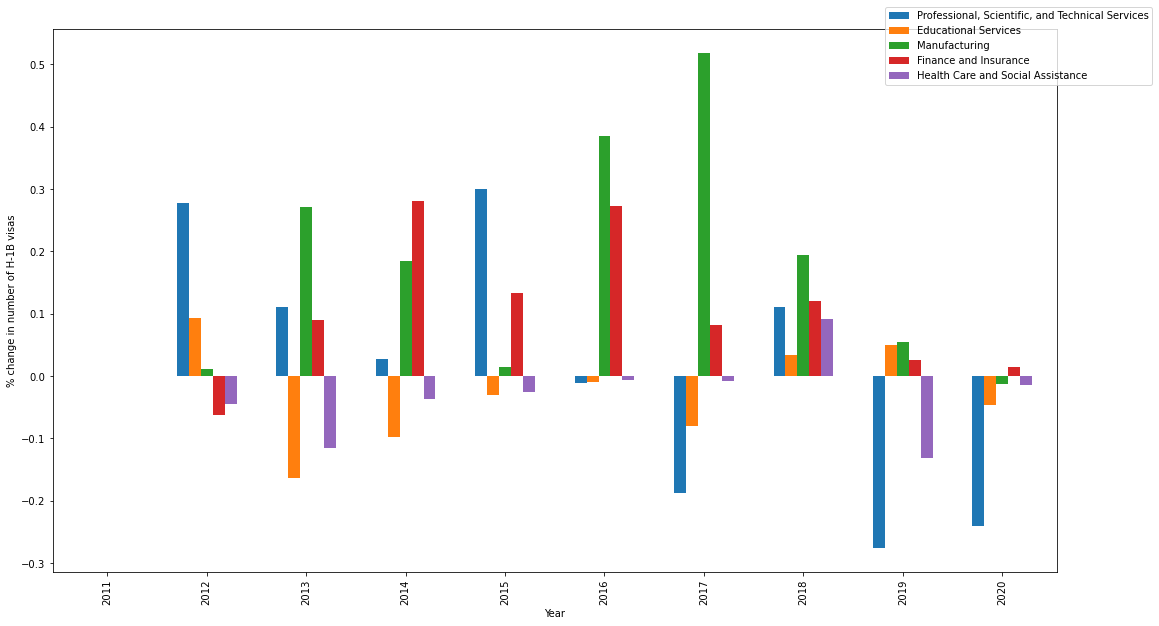

In [51]:
plot_data_df_forplot = df[['Professional, Scientific, and Technical Services','Educational Services','Manufacturing','Finance and Insurance','Health Care and Social Assistance']]
plot_data_df_forplot.plot(ylabel="% change in number of H-1B visas", xlabel="Year", kind="bar", figsize = (18,10), width = 0.6)
plt.legend(bbox_to_anchor = (1.1, 1.05))
plt.show

## Hypothesis 2

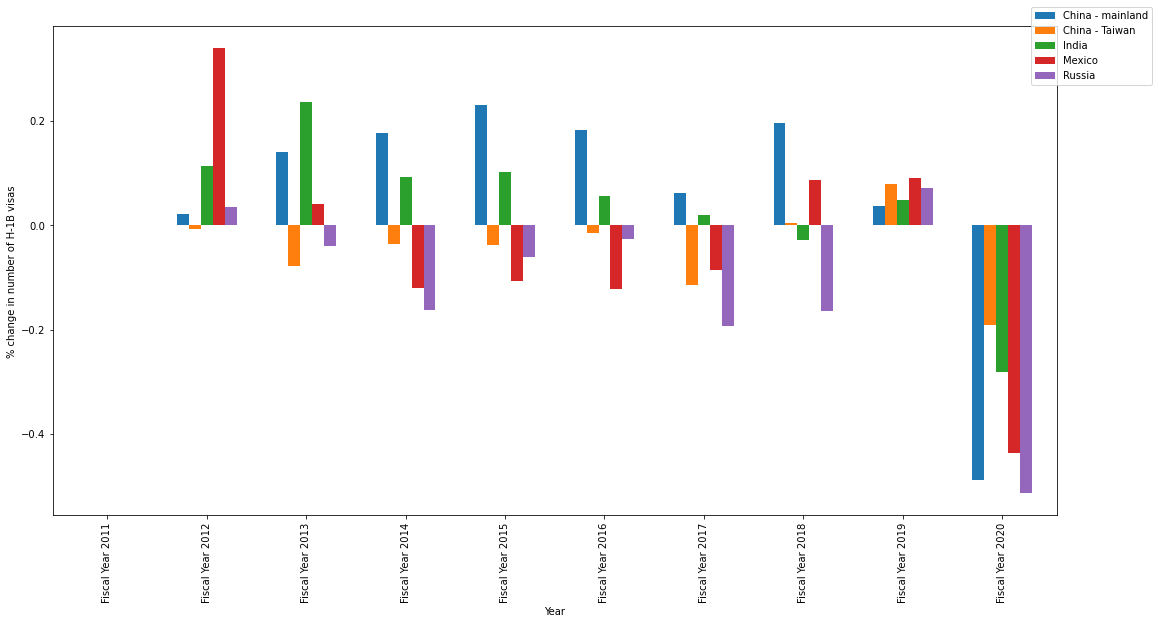

In [61]:
sd= hypothesis_two(directory2)


In [14]:
sd

,Nationality,Fiscal Year 2011,Fiscal Year 2012,Fiscal Year 2013,Fiscal Year 2014,Fiscal Year 2015,Fiscal Year 2016,Fiscal Year 2017,Fiscal Year 2018,Fiscal Year 2019,Fiscal Year 2020
0,China - mainland,10849.0,11077.0,12632.0,14871.0,18306.0,21657.0,22993.0,27482.0,28483.0,14600.0
1,China - Taiwan,1705.0,1692.0,1560.0,1505.0,1448.0,1425.0,1261.0,1266.0,1366.0,1105.0
2,India,72438.0,80630.0,99705.0,108817.0,119952.0,126692.0,129097.0,125528.0,131549.0,94558.0
3,"Korea, South",3501.0,3131.0,3000.0,2727.0,2526.0,2377.0,1939.0,1881.0,2041.0,1076.0
4,Mexico,2647.0,3543.0,3686.0,3243.0,2894.0,2540.0,2322.0,2524.0,2754.0,1552.0
5,Brazil,1614.0,1583.0,1451.0,1352.0,1258.0,1253.0,1113.0,1120.0,1209.0,682.0
6,Australia,537.0,427.0,416.0,424.0,373.0,412.0,384.0,415.0,483.0,285.0
7,Russia,883.0,914.0,878.0,735.0,690.0,672.0,542.0,453.0,485.0,236.0
8,Great Britain and Northern Ireland,3660.0,3019.0,2699.0,2509.0,2111.0,1769.0,1477.0,1378.0,1368.0,761.0
9,Germany,1627.0,1446.0,1274.0,1213.0,1091.0,1061.0,865.0,775.0,844.0,441.0


## Popular State Analysis

In [15]:
df = hypothesis_two_state(directory)


In [16]:
df

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,California,California,California,California,California,California,California,California,California,California
1,New York,New York,Texas,Texas,Texas,Texas,Texas,Texas,Texas,Texas
2,Texas,Texas,New York,New York,New York,New York,New York,New York,New York,New York
3,New Jersey,New Jersey,New Jersey,New Jersey,New Jersey,New Jersey,New Jersey,New Jersey,Florida,Washington
4,Illinois,Illinois,Illinois,Illinois,Illinois,Pennsylvania,Illinois,Illinois,Illinois,New Jersey


## Hypothesis 3

In [17]:
hypothesis3_df = df_hypothesis_three(directory)

In [25]:
hypothesis3_df = hypothesis3_df[hypothesis3_df.MarketCap_x != 0.000000e+00	]

In [26]:
hypothesis3_df[hypothesis3_df.year_x == '2011'].sort_values(by='Rate', ascending=False).head(5)

,EMPLOYER_NAME,Rate,MarketCap_x,year_x
0,"ABIOMED, INC.",100.0,1.620249e+10,2011
230,MCGRATH RENTCORP,100.0,1.261984e+09,2011
199,IPG PHOTONICS CORPORATION,100.0,8.170226e+09,2011
203,"J.B. HUNT TRANSPORT SERVICES, INC.",100.0,1.237240e+10,2011
204,"JACK HENRY & ASSOCIATES, INC.",100.0,1.025214e+10,2011


In [27]:
hypothesis3_df[hypothesis3_df.year_x == '2011'].sort_values(by='Rate', ascending=False).tail(5)

,EMPLOYER_NAME,Rate,MarketCap_x,year_x
107,"DEXCOM, INC.",50.000000,1.314008e+10,2011
172,"H&E EQUIPMENT SERVICES, INC.",50.000000,9.973477e+08,2011
326,"SHOTSPOTTER, INC.",33.333333,5.215000e+08,2011
72,CEMTREX INC.,25.000000,1.119481e+07,2011
200,IROBOT CORPORATION,25.000000,3.336530e+09,2011


In [28]:
hypothesis3_df[hypothesis3_df.year_x == '2015'].sort_values(by='Rate', ascending=False).head(5)

,EMPLOYER_NAME,Rate,MarketCap_x,year_x
1696,"2U, INC.",100.0,4.011720e+09,2015
1910,"INTUITIVE SURGICAL, INC.",100.0,6.275922e+10,2015
1938,"MACROGENICS, INC.",100.0,9.360386e+08,2015
1935,"LIVEPERSON, INC.",100.0,1.667832e+09,2015
1933,"LIQUIDITY SERVICES, INC.",100.0,2.341503e+08,2015


In [32]:
hypothesis3_df[hypothesis3_df.year_x == '2015'].sort_values(by='Rate', ascending=False).tail(5)

,EMPLOYER_NAME,Rate,MarketCap_x,year_x
2037,"REALPAGE, INC.",28.571429,5.527638e+09,2015
1908,INTREXON CORPORATION,25.000000,1.249600e+09,2015
1752,BIOMARIN PHARMACEUTICAL INC.,25.000000,1.635500e+10,2015
2122,"WOODWARD, INC.",25.000000,5.920194e+09,2015
1928,LATTICE SEMICONDUCTOR CORPORATION,14.285714,1.454566e+09,2015


In [30]:
hypothesis3_df[hypothesis3_df.year_x == '2017'].sort_values(by='Rate', ascending=False).tail(5)

,EMPLOYER_NAME,Rate,MarketCap_x,year_x
2844,LATTICE SEMICONDUCTOR CORPORATION,25.000000,1.454566e+09,2017
2850,LIBERTY MEDIA CORPORATION,25.000000,1.473893e+09,2017
2854,LIBERTY MEDIA CORPORATION,25.000000,7.091870e+09,2017
2858,LIBERTY MEDIA CORPORATION,25.000000,1.321896e+10,2017
2749,"ETSY, INC.",18.181818,6.659031e+09,2017


In [33]:
hypothesis3_df[hypothesis3_df.year_x == '2017'].sort_values(by='Rate', ascending=False).head(5)

,EMPLOYER_NAME,Rate,MarketCap_x,year_x
2589,"2U, INC.",100.0,4.011720e+09,2017
2868,"MACROGENICS, INC.",100.0,9.360386e+08,2017
2866,"LOGMEIN, INC.",100.0,4.249600e+09,2017
2865,"LITTELFUSE, INC.",100.0,4.692993e+09,2017
2864,"LIQUIDITY SERVICES, INC.",100.0,2.341503e+08,2017


In [34]:
hypothesis3_df[hypothesis3_df.year_x == '2020'].sort_values(by='Rate', ascending=False).head(5)

,EMPLOYER_NAME,Rate,MarketCap_x,year_x
4084,"2U, Inc.",100.0,4.011720e+09,2020
4452,National Instruments Corporation,100.0,6.015088e+09,2020
4475,"Omnicell, Inc.",100.0,3.288977e+09,2020
4474,Omeros Corporation,100.0,6.812294e+08,2020
4473,"Ocular Therapeutix, Inc.",100.0,1.520529e+08,2020


In [36]:
hypothesis3_df[hypothesis3_df.year_x == '2020'].sort_values(by='Rate', ascending=False).tail(5)

,EMPLOYER_NAME,Rate,MarketCap_x,year_x
4616,"THE ULTIMATE SOFTWARE GROUP, INC.",33.333333,1.198082e+10,2020
4272,"EVERQUOTE, INC.",25.000000,1.408997e+08,2020
4472,"OVERSTOCK.COM, INC.",22.222222,7.120353e+08,2020
4105,"AUTODESK, INC.",21.428571,3.519034e+10,2020
4569,SYMANTEC CORPORATION,4.166667,1.469560e+10,2020
